In [63]:
from torchvision.datasets import CIFAR10  # https://www.cs.toronto.edu/~kriz/cifar.html

In [64]:
#!g1.1
dataset_train = CIFAR10('/home/jupyter/mnt/datasets/cifar10', train=True, transform=T.ToTensor())

means = (dataset_train.data / 255).mean(axis=(0, 1, 2))

stds = (dataset_train.data / 255).std(axis=(0, 1, 2))

In [65]:
# import torchvision.transforms as T

# transforms = T.Compose(
#     [
#         T.ToTensor(),
#         T.Normalize(mean=means, std=stds)
#     ]
# )

In [66]:
# #!g1.1
# from torch.utils.data import DataLoader


# train_dataset = CIFAR10('/home/jupyter/mnt/datasets/cifar10', train=True, transform=transforms)
# valid_dataset = CIFAR10('/home/jupyter/mnt/datasets/cifar10', train=False, transform=transforms)

# train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=8, pin_memory=True)
# valid_loader = DataLoader(valid_dataset, batch_size=128, shuffle=False, num_workers=8, pin_memory=True)

In [67]:
import torch.nn as nn

def create_simple_conv_cifar():
    return nn.Sequential(
                nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1),  # 32 x 32 x 16
                nn.BatchNorm2d(16),
                nn.ReLU(),

                nn.MaxPool2d(2),  # 16 x 16 x 16
                nn.Dropout2d(p=0.2),

                nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),  # 16 x 16 x 32
                nn.BatchNorm2d(32),
                nn.ReLU(),

                nn.MaxPool2d(2),  # 8 x 8 x 32
                nn.Dropout2d(p=0.2),

                nn.Flatten(),

                nn.Linear(8 * 8 * 32, 1024),
                nn.BatchNorm1d(1024),
                nn.ReLU(),
                nn.Linear(1024, 128),
                nn.BatchNorm1d(128),
                nn.ReLU(),
                nn.Linear(128, 10)
            )

In [68]:
#!g1.1

import torchvision.transforms as T

train_transforms = T.Compose(
    [
        T.RandomResizedCrop(size=32, scale=(0.8, 1.1)),
        T.RandomHorizontalFlip(p=0.5),
        T.RandomAdjustSharpness(sharpness_factor=2),
        T.ToTensor(),
        T.Normalize(mean=means, std=stds)
    ]
)

test_transforms = T.Compose(
    [
        T.ToTensor(),
        T.Normalize(mean=means, std=stds)
    ]
)

train_dataset = CIFAR10('/home/jupyter/mnt/datasets/cifar10', train=True, transform=train_transforms)
valid_dataset = CIFAR10('/home/jupyter/mnt/datasets/cifar10', train=False, transform=test_transforms)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=8, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=128, shuffle=False, num_workers=8, pin_memory=True)

In [69]:
#!g1.1
from tqdm import tqdm


def train(model) -> float:
    model.train()

    train_loss = 0
    total = 0
    correct = 0

    for x, y in tqdm(train_loader, desc='Train'):
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()

        output = model(x)

        loss = loss_fn(output, y)

        train_loss += loss.item()

        loss.backward()

        optimizer.step()
        
        _, y_pred = torch.max(output, 1)
        total += y.size(0)
        correct += (y_pred == y).sum().item()

    train_loss /= len(train_loader)
    accuracy = correct / total

    return train_loss, accuracy

In [70]:
import torch

#!g1.1
@torch.inference_mode()
def evaluate(model, loader) -> tuple[float, float]:
    model.eval()

    total_loss = 0
    total = 0
    correct = 0

    for x, y in tqdm(loader, desc='Evaluation'):
        x, y = x.to(device), y.to(device)

        output = model(x)

        loss = loss_fn(output, y)

        total_loss += loss.item()

        _, y_pred = torch.max(output, 1)
        total += y.size(0)
        correct += (y_pred == y).sum().item()

    total_loss /= len(loader)
    accuracy = correct / total

    return total_loss, accuracy

In [71]:
import torch

#!g1.1
@torch.inference_mode()
def evaluate_tta(model, loader, iterations: int = 2) -> tuple[float, float]:
    model.eval()

    total_loss = 0
    total = 0
    correct = 0
    
    iteration_outputs = []
    final_y = []
    
    for i in range(iterations):
        outputs = []
        ys = []
        
        for x, y in tqdm(loader, desc='Evaluation'):
            x, y = x.to(device), y.to(device)

            output = model(x)

            outputs.append(output)
            ys.append(y)
            
        iteration_outputs.append(torch.cat(outputs, 0))
    
    final_outputs = torch.stack(iteration_outputs, 0).mean(0)
    final_y = torch.cat(ys, 0)
    
    loss = loss_fn(final_outputs, final_y)
    
    _, y_pred = torch.max(final_outputs, 1)
    
    total += final_y.size(0)
    correct += (y_pred == final_y).sum().item()
    
    accuracy = correct / total
    
    return loss, accuracy


In [72]:
#!g1.1
import matplotlib.pyplot as plt
from IPython.display import clear_output

def plot_stats(
    train_loss: list[float],
    valid_loss: list[float],
    train_accuracy: list[float],
    valid_accuracy: list[float],
    title: str
):
    plt.figure(figsize=(16, 8))

    plt.title(title + ' loss')

    plt.plot(train_loss, label='Train loss')
    plt.plot(valid_loss, label='Valid loss')
    plt.legend()
    plt.grid()

    plt.show()

    plt.figure(figsize=(16, 8))

    plt.title(title + ' accuracy')
    
    plt.plot(train_accuracy, label='Train accuracy')
    plt.plot(valid_accuracy, label='Valid accuracy')
    plt.legend()
    plt.grid()

    plt.show()


In [33]:
#!g1.1
def whole_train_valid_cycle(model, num_epochs, title):
    train_loss_history, valid_loss_history = [], []
    train_accuracy_history, valid_accuracy_history = [], []

    for epoch in range(num_epochs):
        train_loss, train_accuracy = train(model)
        valid_loss, valid_accuracy = evaluate(model, valid_loader)

        train_loss_history.append(train_loss)
        valid_loss_history.append(valid_loss)

        train_accuracy_history.append(train_accuracy)
        valid_accuracy_history.append(valid_accuracy)

        clear_output()

        plot_stats(
            train_loss_history, valid_loss_history,
            train_accuracy_history, valid_accuracy_history,
            title
        )


In [73]:
#!g1.1
import torch.nn as nn
from torch.optim import Adam

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(device)
print(torch.cuda.get_device_name())

cuda:0
Tesla V100-SXM2-32GB


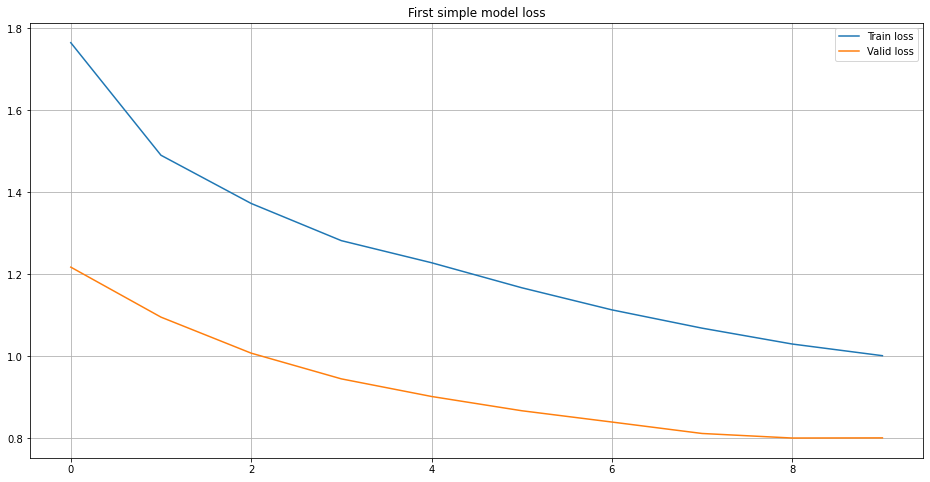

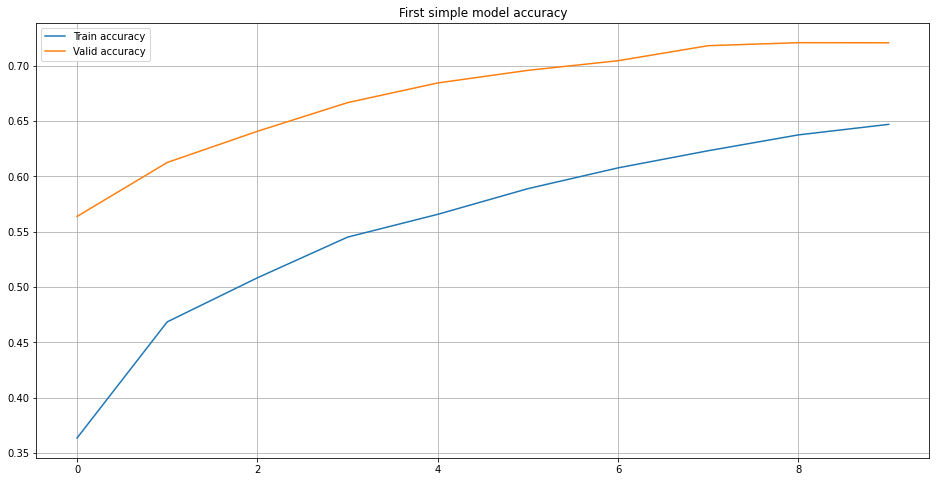

In [19]:
#!g1.1


loss_fn = nn.CrossEntropyLoss()

model = create_simple_conv_cifar().to(device)

optimizer = Adam(model.parameters(), lr=1e-3)

whole_train_valid_cycle(model, 10, 'First simple model')

In [20]:
#!g1.1
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

@torch.inference_mode()
def predict(model: nn.Module, loader: DataLoader, device: torch.device):
    model.eval()
    
    predictions = []
    
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        
        output = model(x)

        _, y_pred = torch.max(output, 1)
        
        predictions.append(y_pred)
    
    return torch.cat(predictions)

In [21]:
#!g1.1
prediction = predict(model, valid_loader, device)

torch.save(prediction, 'prediction.pt')

In [77]:
def create_advanced_conv_cifar():
    return nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),  # 32 x 32 x 32
            nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),  # 32 x 32 x 32
            nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.MaxPool2d(2),  # 16 x 16 x 32
            nn.Dropout2d(p=0.2),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),  # 16 x 16 x 64
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),  # 16 x 16 x 64
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2),  # 8 x 8 x 32
            nn.Dropout2d(p=0.2),

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),  # 8 x 8 x 128
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),  # 8 x 8 x 128
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.MaxPool2d(2),  # 4 x 4 x 128
            nn.Dropout2d(p=0.2),

            nn.Flatten(),

            nn.Linear(4 * 4 * 128, 512),
            nn.BatchNorm1d(512),
            nn.Dropout(p=0.3),
            nn.ReLU(),
            nn.Linear(512, 10)
            )

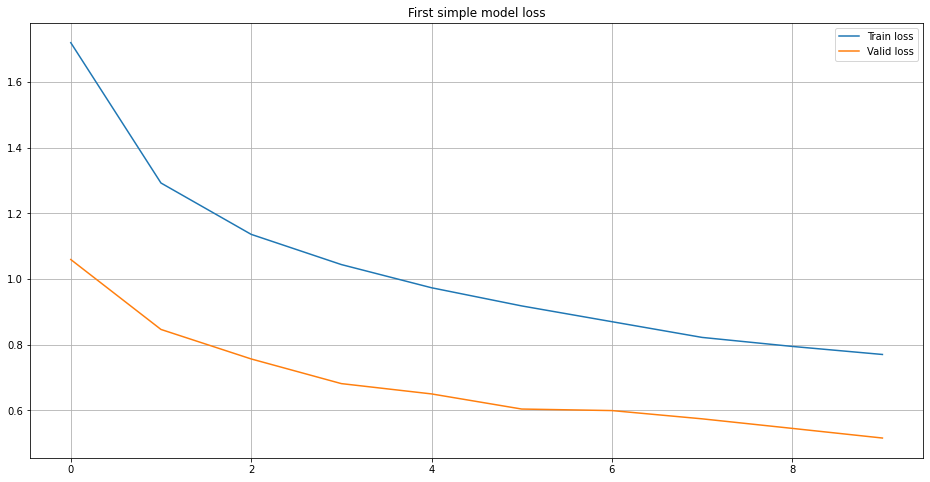

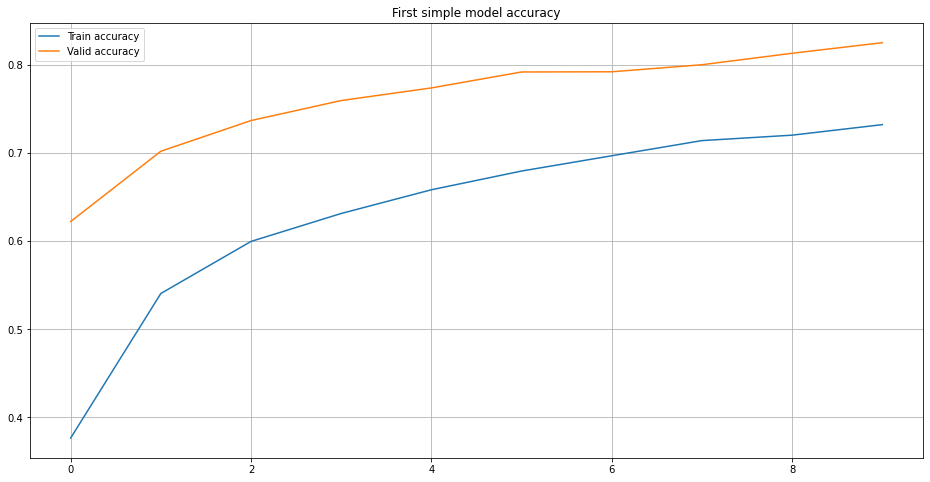

In [24]:
#!g1.1
import torch.nn as nn
from torch.optim import Adam

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(device)
print(torch.cuda.get_device_name())

loss_fn = nn.CrossEntropyLoss()

model = create_advanced_conv_cifar().to(device)

optimizer = Adam(model.parameters(), lr=1e-3)

whole_train_valid_cycle(model, 10, 'First simple model')

In [78]:
#!g1.1

#https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate

def whole_train_valid_cycle_with_scheduler(model, num_epochs, title):
    train_loss_history, valid_loss_history = [], []
    train_accuracy_history, valid_accuracy_history = [], []

    for epoch in range(num_epochs):
        train_loss, train_accuracy = train(model)
        valid_loss, valid_accuracy = evaluate(model, valid_loader)

        train_loss_history.append(train_loss)
        valid_loss_history.append(valid_loss)

        train_accuracy_history.append(train_accuracy)
        valid_accuracy_history.append(valid_accuracy)

        clear_output()

        plot_stats(
            train_loss_history, valid_loss_history,
            train_accuracy_history, valid_accuracy_history,
            title
        )

        scheduler.step()


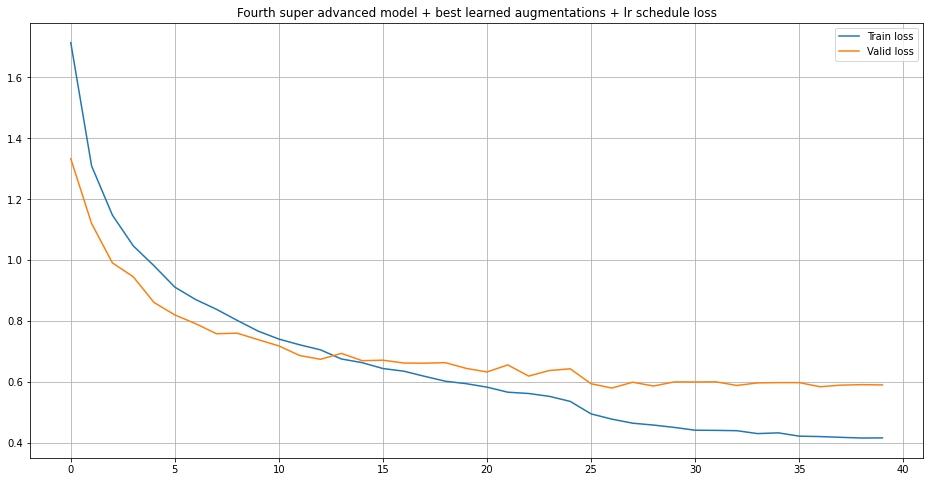

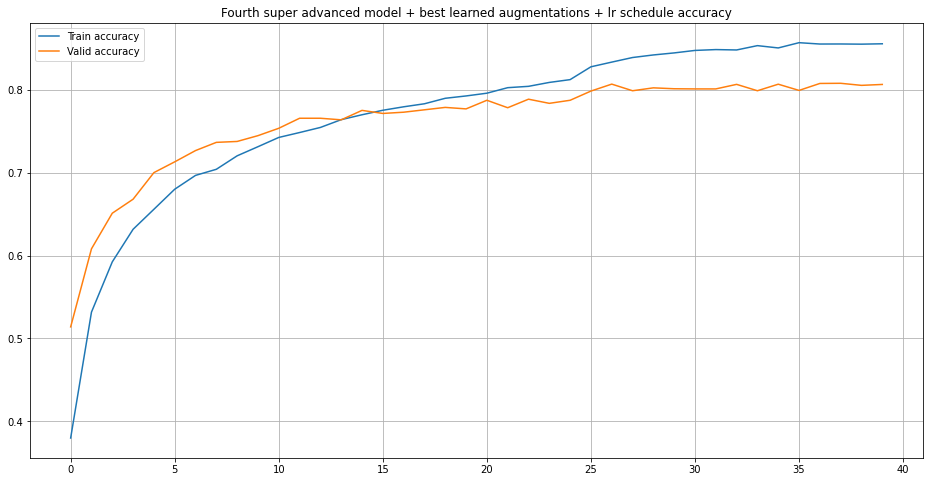

Task is done, waiting for foreground cells to finish...
Merging task result to the state
Cannot apply result: following variables are changed in this cell and need manual merge: scheduler, optimizer, model, evaluate_tta, plot_stats, evaluate, train
To apply changes run: %apply_state 94b36e6b-dc46-4449-a1a0-c4f77f4ee886/2f3d806d-db1f-4c9e-96a2-3204dd71c598

In [79]:
#!g1.1
#pragma async
from torch.optim.lr_scheduler import StepLR

model = create_advanced_conv_cifar().to(device)

optimizer = Adam(model.parameters(), lr=1e-3)
scheduler = StepLR(optimizer, step_size=25)

whole_train_valid_cycle_with_scheduler(model, 40, 'Fourth super advanced model + best learned augmentations + lr schedule')

In [ ]:
#!g1.1
